# LSTM w/ GPU w/ npz

- Data preprocessing was done by other [notebook](https://www.kaggle.com/seungmoklee/lstm-preprocessing-point-picker).
- I need to train more!
- Let's use GPU!

In [1]:
# Data I/O and preprocessing
import numpy as np

# System
import time
import os
import gc

# Graphic
import matplotlib.pyplot as plt

from tqdm import tqdm

%matplotlib inline

# Global Setting

In [2]:
# directory
icecube_dir = "/kaggle/input/icecube-neutrinos-in-deep-ice/"
model_dir = "/kaggle/input/icecubemodels/"
data_dir = "/kaggle/input/icecubedata/"

In [3]:
# data
bin_num = 16

train_batch_id_min = 101
train_batch_id_max = 105

train_batch_ids = range(train_batch_id_min, train_batch_id_max + 1)

# model
LSTM_width = 160
DENSE_width = 0

# training
validation_split = 0.05
seed = 220242
epochs = 20
batch_size = 128
fit_verbose = 1

In [4]:
# data preprocessing
point_picker_format = data_dir + './pointpicker_mpc128_n9_batch_{batch_id:d}.npz'

# model
model_output_path = model_dir + f"PointPicker_mpc128bin{bin_num}_LSTM{LSTM_width}DENSE{DENSE_width}"

# Prepare Metric

## Scoring functions

In [5]:
def angular_dist_score(az_true, zen_true, az_pred, zen_pred):
    '''
    calculate the MAE of the angular distance between two directions.
    The two vectors are first converted to cartesian unit vectors,
    and then their scalar product is computed, which is equal to
    the cosine of the angle between the two vectors. The inverse 
    cosine (arccos) thereof is then the angle between the two input vectors
    
    Parameters:
    -----------
    
    az_true : float (or array thereof)
        true azimuth value(s) in radian
    zen_true : float (or array thereof)
        true zenith value(s) in radian
    az_pred : float (or array thereof)
        predicted azimuth value(s) in radian
    zen_pred : float (or array thereof)
        predicted zenith value(s) in radian
    
    Returns:
    --------
    
    dist : float
        mean over the angular distance(s) in radian
    '''
    
    if not (np.all(np.isfinite(az_true)) and
            np.all(np.isfinite(zen_true)) and
            np.all(np.isfinite(az_pred)) and
            np.all(np.isfinite(zen_pred))):
        raise ValueError("All arguments must be finite")
    
    # pre-compute all sine and cosine values
    sa1 = np.sin(az_true)
    ca1 = np.cos(az_true)
    sz1 = np.sin(zen_true)
    cz1 = np.cos(zen_true)
    
    sa2 = np.sin(az_pred)
    ca2 = np.cos(az_pred)
    sz2 = np.sin(zen_pred)
    cz2 = np.cos(zen_pred)
    
    # scalar product of the two cartesian vectors (x = sz*ca, y = sz*sa, z = cz)
    scalar_prod = sz1*sz2*(ca1*ca2 + sa1*sa2) + (cz1*cz2)
    
    # scalar product of two unit vectors is always between -1 and 1, this is against nummerical instability
    # that might otherwise occure from the finite precision of the sine and cosine functions
    scalar_prod =  np.clip(scalar_prod, -1, 1)
    
    # convert back to an angle (in radian)
    return np.average(np.abs(np.arccos(scalar_prod)))

## Angle One-hot Encoding

- azimuth and zenith are independent
- azimuth distribution is flat and zenith distribution is sin
  - Flat on the spherical surface
  - $\phi > \pi$ events are a little bit rarer than $\phi < \pi$ events, (maybe) because of the neutrino attenuation by earth.
- So, the uniform bin is used for azimuth, and $\left| \cos \right|$ bin is used for zenith

In [6]:
azimuth_edges = np.linspace(0, 2 * np.pi, bin_num + 1)
zenith_edges_flat = np.linspace(0, np.pi, bin_num + 1)
zenith_edges = list()
zenith_edges.append(0)
for bin_idx in range(1, bin_num):
    # cos(zen_before) - cos(zen_now) = 2 / bin_num
    zen_now = np.arccos(np.cos(zenith_edges[-1]) - 2 / (bin_num))
    zenith_edges.append(zen_now)
zenith_edges.append(np.pi)
zenith_edges = np.array(zenith_edges)

In [7]:
def y_to_onehot(batch_y):
    # evaluate bin code
    azimuth_code = (batch_y[:, 0] > azimuth_edges[1:].reshape((-1, 1))).sum(axis=0)
    zenith_code = (batch_y[:, 1] > zenith_edges[1:].reshape((-1, 1))).sum(axis=0)
    angle_code = bin_num * azimuth_code + zenith_code

    # one-hot
    batch_y_onehot = np.zeros((angle_code.size, bin_num * bin_num))
    batch_y_onehot[np.arange(angle_code.size), angle_code] = 1
    
    return batch_y_onehot

## Define a function converts from prediction to angles

- Calculation of the mean-vector in a bin $\theta \in ( \theta_0, \theta_1 )$ and $\phi \in ( \phi_0, \phi_1 )$
  - $\vec{r} \left( \theta, ~ \phi \right) = \left< \sin \theta \cos \phi, ~ \sin \theta \sin \phi, ~ \cos \theta \right>$
  - $\bar{\vec{r}} = \frac{ \int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} \vec{r} \left( \theta, ~ \phi \right) \sin \theta \,d\phi \,d\theta }{ \int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} 1 \sin \theta \,d\phi \,d\theta }$
  - $ \int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} 1 \sin \theta \,d\phi \,d\theta = \left( \phi_1 - \phi_0 \right) \left( \cos \theta_0 - \cos \theta_1 \right)$
  - $
\int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} {r}_{x} \left( \theta, ~ \phi \right) \sin \theta \,d\phi \,d\theta = 
\int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} \sin^2 \theta \cos \phi \,d\phi \,d\theta = 
\left( \sin \phi_1 - \sin \phi_0 \right) \left( \frac{\theta_1 - \theta_0}{2} - \frac{\sin 2 \theta_1 - \sin 2 \theta_0}{4} \right)
$
  - $
\int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} {r}_{y} \left( \theta, ~ \phi \right) \sin \theta \,d\phi \,d\theta = 
\int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} \sin^2 \theta \sin \phi \,d\phi \,d\theta = 
\left( \cos \phi_0 - \cos \phi_1 \right) \left( \frac{\theta_1 - \theta_0}{2} - \frac{\sin 2 \theta_1 - \sin 2 \theta_0}{4} \right)
$
  - $
\int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} {r}_{z} \left( \theta, ~ \phi \right) \sin \theta \,d\phi \,d\theta = 
\int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} \sin \theta \cos \theta \,d\phi \,d\theta = 
\left( \phi_1 - \phi_0 \right) \left( \frac{\cos 2 \theta_0 - \cos 2 \theta_1}{4} \right)
$

In [8]:
angle_bin_zenith0 = np.tile(zenith_edges[:-1], bin_num)
angle_bin_zenith1 = np.tile(zenith_edges[1:], bin_num)
angle_bin_azimuth0 = np.repeat(azimuth_edges[:-1], bin_num)
angle_bin_azimuth1 = np.repeat(azimuth_edges[1:], bin_num)

angle_bin_area = (angle_bin_azimuth1 - angle_bin_azimuth0) * (np.cos(angle_bin_zenith0) - np.cos(angle_bin_zenith1))
angle_bin_vector_sum_x = (np.sin(angle_bin_azimuth1) - np.sin(angle_bin_azimuth0)) * ((angle_bin_zenith1 - angle_bin_zenith0) / 2 - (np.sin(2 * angle_bin_zenith1) - np.sin(2 * angle_bin_zenith0)) / 4)
angle_bin_vector_sum_y = (np.cos(angle_bin_azimuth0) - np.cos(angle_bin_azimuth1)) * ((angle_bin_zenith1 - angle_bin_zenith0) / 2 - (np.sin(2 * angle_bin_zenith1) - np.sin(2 * angle_bin_zenith0)) / 4)
angle_bin_vector_sum_z = (angle_bin_azimuth1 - angle_bin_azimuth0) * ((np.cos(2 * angle_bin_zenith0) - np.cos(2 * angle_bin_zenith1)) / 4)

angle_bin_vector_mean_x = angle_bin_vector_sum_x / angle_bin_area
angle_bin_vector_mean_y = angle_bin_vector_sum_y / angle_bin_area
angle_bin_vector_mean_z = angle_bin_vector_sum_z / angle_bin_area

angle_bin_vector = np.zeros((1, bin_num * bin_num, 3))
angle_bin_vector[:, :, 0] = angle_bin_vector_mean_x
angle_bin_vector[:, :, 1] = angle_bin_vector_mean_y
angle_bin_vector[:, :, 2] = angle_bin_vector_mean_z

In [9]:
def pred_to_angle(pred, epsilon=1e-8):
    # convert prediction to vector
    pred_vector = (pred.reshape((-1, bin_num * bin_num, 1)) * angle_bin_vector).sum(axis=1)
    
    # normalize
    pred_vector_norm = np.sqrt((pred_vector**2).sum(axis=1))
    mask = pred_vector_norm < epsilon
    pred_vector_norm[mask] = 1
    
    # assign <1, 0, 0> to very small vectors (badly predicted)
    pred_vector /= pred_vector_norm.reshape((-1, 1))
    pred_vector[mask] = np.array([1., 0., 0.])
    
    # convert to angle
    azimuth = np.arctan2(pred_vector[:, 1], pred_vector[:, 0])
    azimuth[azimuth < 0] += 2 * np.pi
    zenith = np.arccos(pred_vector[:, 2])
    
    return azimuth, zenith

# Read Feature Data

- max_pulse_counts 256
    - RAM USAGE = 1.8 GB / batch
      - 608 MB -> 2.3 GB for one batch reading
      - Reading 3 batches -> 5.9 GB
    - 7.3 GB after here (4 batches) with GPU
- max_pulse_counts 128
    - 7.3 GB after here (4 batches) with GPU
    - It is almost marginal

## Read feature data for training

In [10]:
print("Reading training data...")

train_x = None
train_y = None
for batch_id in tqdm(train_batch_ids):
    train_data_file = np.load(point_picker_format.format(batch_id=batch_id))
    
    if train_x is None:
        train_x = train_data_file["x"]
        train_y = train_data_file["y"]
    else:
        train_x = np.append(train_x, train_data_file["x"], axis=0)
        train_y = np.append(train_y, train_data_file["y"], axis=0)
        
    train_data_file.close()
    del train_data_file
    _ = gc.collect()

Reading training data...


100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


# Data Preprocessing

## Rough Normalization and One-hot Encoding

- Time $\div$ 1000 ns -> time `[0, 3]`
- Charge $\div$ 300 -> charge `[0, 2.5]`
- $\left( X,~Y,~Z \right) \div$ 600 m -> space `[-1, 1]`
  - their errors as well

In [11]:
train_x[:, :, 0] /= 1000  # time
train_x[:, :, 1] /= 300  # charge
train_x[:, :, 3:] /= 600  # space

train_y_onehot = y_to_onehot(train_y)

## Split validation samples

In [12]:
num_valid = int(validation_split * len(train_x))

valid_x = train_x[-num_valid:]
valid_y = train_y[-num_valid:]
valid_y_onehot = train_y_onehot[-num_valid:]

train_x = train_x[:-num_valid]
train_y = train_y[:-num_valid]
train_y_onehot = train_y_onehot[:-num_valid]

In [13]:
print(f"{'data':16s}" + f"{'shape':24s}" + f"{'mem [MB]':8s}")
print(f"{'train_x':16s}" + f"{str(train_x.shape):24s}" + f"{train_x.nbytes / 1024 / 1024:.4f}"[:8])
print(f"{'train_y':16s}" + f"{str(train_y.shape):24s}" + f"{train_y.nbytes / 1024 / 1024:.4f}"[:8])
print(f"{'train_y_onehot':16s}" + f"{str(train_y_onehot.shape):24s}" + f"{train_y_onehot.nbytes / 1024 / 1024:.4f}"[:8])
print("-" * (16 + 24 + 8))
print(f"{'valid_x':16s}" + f"{str(valid_x.shape):24s}" + f"{valid_x.nbytes / 1024 / 1024:.4f}"[:8])
print(f"{'valid_y':16s}" + f"{str(valid_y.shape):24s}" + f"{valid_y.nbytes / 1024 / 1024:.4f}"[:8])
print(f"{'valid_y_onehot':16s}" + f"{str(valid_y_onehot.shape):24s}" + f"{valid_y_onehot.nbytes / 1024 / 1024:.4f}"[:8])
print("-" * (16 + 24 + 8))
total = (train_x.nbytes + train_y.nbytes + train_y_onehot.nbytes + valid_x.nbytes + valid_y.nbytes + valid_y_onehot.nbytes) / 1024 / 1024
print(f"{'total':16s}" + f"{'':24s}" + f"{total:.4f}"[:8])
print("        real RAM usage can be doubled...")

data            shape                   mem [MB]
train_x         (950000, 128, 9)        2087.402
train_y         (950000, 2)             3.6240
train_y_onehot  (950000, 256)           1855.468
------------------------------------------------
valid_x         (50000, 128, 9)         109.8633
valid_y         (50000, 2)              0.1907
valid_y_onehot  (50000, 256)            97.6562
------------------------------------------------
total                                   4154.205
        real RAM usage can be doubled...


## hyperparameters for LSTM model

In [14]:
max_pulse_count = train_x.shape[1]
n_features = train_x.shape[2]

print(" max_pulse_count : ", max_pulse_count)
print("    n_features   : ", n_features)

 max_pulse_count :  128
    n_features   :  9


# Define Neural Network Functions

## Import

In [15]:
import tensorflow as tf
import random

2023-04-08 02:20:22.593799: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 02:20:25.207353: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/conda/lib
2023-04-08 02:20:25.208673: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object

In [16]:
print(f"SEED {seed:d}")

tf.random.set_seed(seed)
random.seed(seed)
np.random.seed(seed)

SEED 220242


## Define & Train Model

In [17]:
print(" LSTM_width : ", LSTM_width)
print("DENSE_width : ", DENSE_width)

 LSTM_width :  160
DENSE_width :  0


In [18]:
# build model
model_inputs = tf.keras.layers.Input((max_pulse_count, n_features))
model_x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_width))(model_inputs)
# model_x = tf.keras.layers.Dense(DENSE_width, activation='relu')(model_x)
model_outputs = tf.keras.layers.Dense(bin_num * bin_num, activation='softmax')(model_x)

model = tf.keras.Model(
    inputs=model_inputs,
    outputs=model_outputs,
    name="model"
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 9)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 320)              217600    
 l)                                                              
                                                                 
 dense (Dense)               (None, 256)               82176     
                                                                 
Total params: 299,776
Trainable params: 299,776
Non-trainable params: 0
_________________________________________________________________


In [19]:
# compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = 'categorical_crossentropy'
metrics = ['accuracy']

model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=metrics
)

In [20]:
# train model
history = model.fit(
    train_x, train_y_onehot,
    validation_data=(valid_x, valid_y_onehot),
    epochs=epochs,
    batch_size=batch_size,
    verbose=fit_verbose,
)

2023-04-08 02:20:55.146243: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 4377600000 exceeds 10% of free system memory.
2023-04-08 02:21:26.465003: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 972800000 exceeds 10% of free system memory.
2023-04-08 02:21:27.692674: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 4377600000 exceeds 10% of free system memory.
2023-04-08 02:21:38.142408: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 972800000 exceeds 10% of free system memory.


Epoch 1/20
7421/7422 [============================>.] - ETA: 0s - loss: 5.4023 - accuracy: 0.0153

2023-04-08 02:25:54.215452: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 230400000 exceeds 10% of free system memory.


7422/7422 [==============================] - 257s 34ms/step - loss: 5.4023 - accuracy: 0.0153 - val_loss: 5.0429 - val_accuracy: 0.0535
Epoch 2/20
7422/7422 [==============================] - 245s 33ms/step - loss: 4.9423 - accuracy: 0.0721 - val_loss: 4.8584 - val_accuracy: 0.0901
Epoch 3/20
7422/7422 [==============================] - 244s 33ms/step - loss: 4.8332 - accuracy: 0.0932 - val_loss: 4.8101 - val_accuracy: 0.0964
Epoch 4/20
7422/7422 [==============================] - 247s 33ms/step - loss: 4.7771 - accuracy: 0.1032 - val_loss: 4.7584 - val_accuracy: 0.1087
Epoch 5/20
7422/7422 [==============================] - 243s 33ms/step - loss: 4.7398 - accuracy: 0.1098 - val_loss: 4.7280 - val_accuracy: 0.1143
Epoch 6/20
7422/7422 [==============================] - 245s 33ms/step - loss: 4.7123 - accuracy: 0.1146 - val_loss: 4.7128 - val_accuracy: 0.1156
Epoch 7/20
7422/7422 [==============================] - 245s 33ms/step - loss: 4.6973 - accuracy: 0.1175 - val_loss: 4.7097 - val

## Save Model

In [21]:
%%time
print("Saving model...")
print(model_output_path)

model.save(model_output_path)

Saving model...
/kaggle/input/icecubemodels/PointPicker_mpc128bin16_LSTM160DENSE0
CPU times: user 12.1 s, sys: 467 ms, total: 12.5 s
Wall time: 13.4 s


## Draw training progress

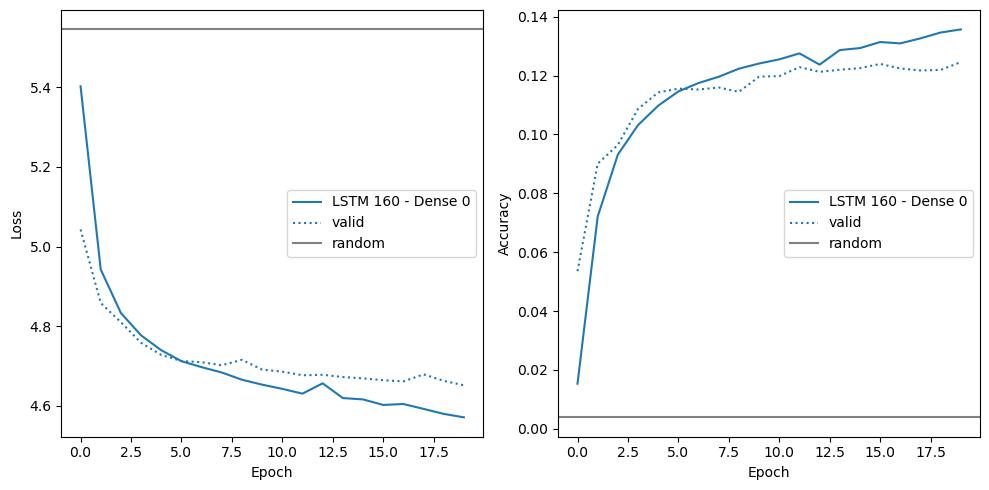

In [22]:
fig = plt.figure(figsize=(10, 5))

label = f"LSTM {LSTM_width:d} - Dense {DENSE_width:d}"

# history - loss
ax = plt.subplot(121)
line = ax.plot(history.epoch, history.history['loss'], label=label)
ax.plot(history.epoch, history.history['val_loss'], linestyle="dotted", color=line[0].get_color(), label="valid")
ax.axhline(np.log(bin_num * bin_num), color="gray", label="random")

ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend()

# history - accuracy
ax = plt.subplot(122)
line = ax.plot(history.epoch, history.history['accuracy'], label=label)
ax.plot(history.epoch, history.history['val_accuracy'], linestyle="dotted", color=line[0].get_color(), label="valid")
ax.axhline(1 / bin_num / bin_num, color="gray", label="random")

ax.set_ylabel("Accuracy")
ax.set_xlabel("Epoch")
ax.legend()

plt.tight_layout()
plt.show()

## Evaluate model

In [23]:
valid_pred = model.predict(valid_x, verbose=1)

valid_pred_azimuth, valid_pred_zenith = pred_to_angle(valid_pred)

mae = angular_dist_score(valid_y[:, 0], valid_y[:, 1], valid_pred_azimuth, valid_pred_zenith)

1563/1563 [==============================] - 21s 13ms/step


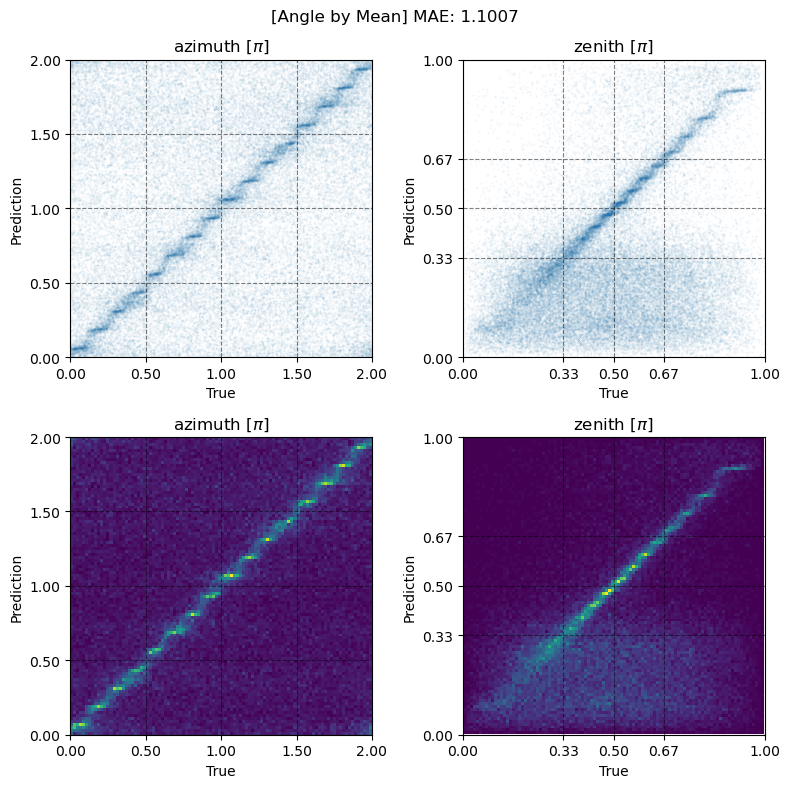

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

ax = axs[0, 0]
ax.scatter(valid_y[:, 0], valid_pred_azimuth, s=0.1, alpha=0.1)
ax.set_xlabel("True")
ax.set_ylabel("Prediction")
ax.set_xlim(0, 2 * np.pi)
ax.set_ylim(0, 2 * np.pi)
ax.set_xticks(azimuth_edges[0::(bin_num//4)])
ax.set_xticklabels(["%.2f" % n for n in azimuth_edges[0::(bin_num//4)] / np.pi])
ax.set_yticks(azimuth_edges[0::(bin_num//4)])
ax.set_yticklabels(["%.2f" % n for n in azimuth_edges[0::(bin_num//4)] / np.pi])
ax.grid(linestyle="dashed", color="black", alpha=0.5)
ax.set_title(r"azimuth [$\pi$]")

ax = axs[0, 1]
ax.scatter(valid_y[:, 1], valid_pred_zenith, s=0.1, alpha=0.1)
ax.set_xlabel("True")
ax.set_ylabel("Prediction")
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)
ax.set_xticks(zenith_edges[0::(bin_num//4)])
ax.set_xticklabels(["%.2f" % n for n in zenith_edges[0::(bin_num//4)] / np.pi])
ax.set_yticks(zenith_edges[0::(bin_num//4)])
ax.set_yticklabels(["%.2f" % n for n in zenith_edges[0::(bin_num//4)] / np.pi])
ax.grid(linestyle="dashed", color="black", alpha=0.5)
ax.set_title(r"zenith [$\pi$]")

ax = axs[1, 0]
ax.hist2d(valid_y[:, 0], valid_pred_azimuth, bins=100)
ax.set_xlabel("True")
ax.set_ylabel("Prediction")
ax.set_xlim(0, 2 * np.pi)
ax.set_ylim(0, 2 * np.pi)
ax.set_xticks(azimuth_edges[0::(bin_num//4)])
ax.set_xticklabels(["%.2f" % n for n in azimuth_edges[0::(bin_num//4)] / np.pi])
ax.set_yticks(azimuth_edges[0::(bin_num//4)])
ax.set_yticklabels(["%.2f" % n for n in azimuth_edges[0::(bin_num//4)] / np.pi])
ax.grid(linestyle="dashed", color="black", alpha=0.5)
ax.set_title(r"azimuth [$\pi$]")

ax = axs[1, 1]
ax.hist2d(valid_y[:, 1], valid_pred_zenith, bins=100)
ax.set_xlabel("True")
ax.set_ylabel("Prediction")
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)
ax.set_xticks(zenith_edges[0::(bin_num//4)])
ax.set_xticklabels(["%.2f" % n for n in zenith_edges[0::(bin_num//4)] / np.pi])
ax.set_yticks(zenith_edges[0::(bin_num//4)])
ax.set_yticklabels(["%.2f" % n for n in zenith_edges[0::(bin_num//4)] / np.pi])
ax.grid(linestyle="dashed", color="black", alpha=0.5)
ax.set_title(r"zenith [$\pi$]")

plt.suptitle(f"[Angle by Mean] MAE: {mae:.4f}")
plt.tight_layout()
plt.show()

# Enable file download

In [25]:
from IPython.display import FileLink

In [26]:
FileLink(model_output_path + "/variables/variables.index")

/kaggle/input/icecubemodels/PointPicker_mpc128bin16_LSTM160DENSE0/variables/variables.index

In [27]:
FileLink(model_output_path + "/variables/variables.data-00000-of-00001")

/kaggle/input/icecubemodels/PointPicker_mpc128bin16_LSTM160DENSE0/variables/variables.data-00000-of-00001

In [28]:
FileLink(model_output_path + "/keras_metadata.pb")

/kaggle/input/icecubemodels/PointPicker_mpc128bin16_LSTM160DENSE0/keras_metadata.pb

In [29]:
FileLink(model_output_path + "/saved_model.pb")

/kaggle/input/icecubemodels/PointPicker_mpc128bin16_LSTM160DENSE0/saved_model.pb

In [30]:
os.listdir(model_output_path + "/variables")

['variables.data-00000-of-00001', 'variables.index']

# END-OF-NOTE